Multinomial Naives Bayes

In [ ]:
# library imported 
import numpy as np
import pandas as pd
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer 
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:

class MultinomialBN():
  """
    this class take k(alpha), and categories 
    input: k, categories
    output : predict new document

  """
  def __init__(self,k, categories):
    """
    this class take k(alpha), and real categories of data 
    input: k, categories
    output : predict new document

    """
    self.k = k
    self.count_categories = {}
    self.prior_categories = {}
    self.word_probs = []
    self.vocabulary_ = []
    self.stop = set(stopwords.words('english'))
    self.stemmer = SnowballStemmer(language = 'english')
    self.lem = WordNetLemmatizer()
    self.categories = categories
  
  def tokenize(self, document):
    """
      process: 
          * remove punctuation  
          * remove stopwords(word that is not very important)
          * stemmetize each word in order to get the stem of the word( eg: driven => drive)
          * lemmatize each word in order to get the lem(using vocabulary similarity) eg : drove => drive
      input: document (sentence that we want to predict eg: "it is not difficult to understand")
      return array of word ([difficult, to, understand])
    """
    data = document.lower()
    # data = [char for char in document if char not in string.punctuation]
    for char in string.punctuation:
      data = data.replace(char, '')
    # data = ''.join(data)
    data = [self.lem.lemmatize(self.stemmer.stem(word)) for word in data.split() if word not in self.stop]
    # data = [word for word in data.split() if word.lower() not in self.stop]
    # data = [self.stemmer.stem(x,) for x in data]
    # data = [self.lem.lemmatize(x,) for x in data]
    return data

  def count_words(self, X, y):
    """
      X: array of tokenize elements
      y: categories of this elements
      return counts : {word: (number of appearition in categories 0, number of appearition in categories 1, number of appearition in categories 2)}
    """
    size = len(X)
    category_size = len(self.categories)

    counts = {}
    for i in range(size):
      for word in X[i]:
        if word not in counts:
          counts[word] = [0] * category_size
        counts[word][y[i]] += 1
    # print(counts)
    return counts

  def prior_prob(self):
    """
      compute the prior probability of each category
      count the number of word of each category
    """
    prior_probabilities = {}
    count_categories = {}
    data_size = len(self.y)
    category_size = len(self.categories)

    init = {}
    for cat in self.categories:
      init[cat] = 0

    # init data
    count_categories = init.copy()
    prior_probabilities = init.copy()

    count_categories['total'] = 0

    for word in self.counts: 
      for cat in self.categories:
        count_categories[cat] += self.counts[word][self.categories.index(cat)]
    
    for cat in self.categories:
      count_categories['total'] += count_categories[cat]

    # print(prior_probabilities)
    for cat in self.categories:
      prior_probabilities[cat] = np.log(self.y.value_counts()[self.categories.index(cat)]/data_size)

    self.prior_probabilities = prior_probabilities
    self.count_categories = count_categories


  def word_probabilities(self,):
    """
    compute the probability of each word 
    """
    vocabulary_size = len(self.counts)
    category_size = len(self.categories)
    # init = {}
    # for cat in self.categories:
    #   init[cat] = 0

    word_probs = {}
    for word in self.counts:
      word_probs[word] = [0] * category_size
      for cat in self.categories:
        word_probs[word][self.categories.index(cat)] = (self.counts[word][self.categories.index(cat)]+self.k)/(self.count_categories[cat] + self.k * vocabulary_size)

    return word_probs

  def fit(self, X, y):
    """
    Process:
      * tokenize each input
      * count the number of word of this dataset
      * compute the prior of each category
      * compute the probability of each word

    this function is used to get the probability of each word 
    """
    self.X = X.apply(self.tokenize)   
    self.y = y

    self.counts = self.count_words(self.X, self.y)
    self.prior_prob()
    self.word_probs = self.word_probabilities()


  def predict(self, X):
    X = X.apply(self.tokenize)
    results = []
    log_proba = {}
    category_size = len(self.categories)

    init = {}
    for cat in self.categories:
      init[cat] = 0

    for document in X:
      prediction = None
      log_proba = init.copy()
      for word in document:
        if word in self.counts:
          for cat in self.categories:
            log_proba[cat] += np.log(self.word_probs[word][self.categories.index(cat)])

      # print(log_proba)
      for cat in self.categories:
        log_proba[cat] = self.prior_probabilities[cat] +  log_proba[cat]
      
      results.append(self.categories.index(max(log_proba, key = log_proba.get)))
    return results

  def accuracy(self, y, yPred):
    return (np.sum(y == yPred)/len(y)) * 100


In [ ]:
#import dataset
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# label encoding
categories = df['sentiment'].unique().tolist()
df['sentiment'] =  df['sentiment'].apply(lambda x : categories.index(x))
print(df.head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          0
1  A wonderful little production. <br /><br />The...          0
2  I thought this was a wonderful way to spend ti...          0
3  Basically there's a family where a little boy ...          1
4  Petter Mattei's "Love in the Time of Money" is...          0


In [ ]:
transformer = MultinomialBN(k=1, categories=categories) #init model

In [ ]:
transformer.tokenize('Hi, I love ate you potatoes sentiments') # just show how tokenizer work

['hi', 'love', 'ate', 'potato', 'sentiment']

In [ ]:
# split the data into train set and test set
ratio = 0.8
size = len(df)
train_size = int(ratio * size)
print(train_size)

X_train, y_train = df['review'][:train_size], df['sentiment'][:train_size]
X_test, y_test = df['review'][train_size:], df['sentiment'][train_size:]


40000


In [ ]:
# training the model
transformer.fit(X_train, y_train)

In [ ]:
yPred = transformer.predict(X_test) # get prediction

In [ ]:
transformer.accuracy(yPred, y_test)

85.71

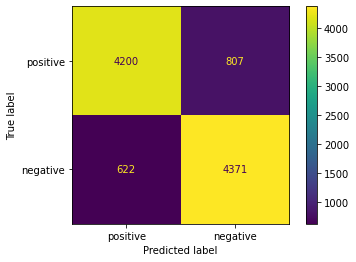

In [ ]:
cm = confusion_matrix(y_test, yPred,)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()

In [ ]:
fast = pd.Series(['love', 'bad'])  
y_fast = transformer.predict(fast)
for pred in y_fast:
  print(categories[pred])

positive
negative


<h1>Spam dataset</h1>

In [ ]:
df3 = pd.read_csv('spam.csv')
df3.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
categories = df3['v1'].unique().tolist()
df3['v1'] =  df3['v1'].apply(lambda x : categories.index(x))
print(df.head(), categories)

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          0
1  A wonderful little production. <br /><br />The...          0
2  I thought this was a wonderful way to spend ti...          0
3  Basically there's a family where a little boy ...          1
4  Petter Mattei's "Love in the Time of Money" is...          0 ['ham', 'spam']


In [ ]:
nb = MultinomialBN(k=1, categories=categories)

In [ ]:
ratio = 0.8
size = len(df3)
arr = np.arange(size)
np.random.shuffle(arr)
df2 = df3.iloc[arr].reset_index()
train_size = int(ratio * size)
# print(train_size)

X_train3, y_train3 = df3['v2'][:train_size], df3['v1'][:train_size]
X_test3, y_test3 = df3['v2'][train_size:], df3['v1'][train_size:]
# print(X_train3, y_train3)

In [ ]:
nb.fit(X_train3, y_train3)

In [ ]:
yPred = nb.predict(X_test3)
nb.accuracy(yPred, y_test3)

98.20627802690582

<h1>Check with a dataset with 3 category</h1>

In [ ]:
df2 = pd.read_csv('mnb.csv')
df2.head()

,Unnamed: 0,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,0,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.390000e+12
1,1,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.390000e+12
2,2,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.390000e+12
3,3,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.390000e+12
4,4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.390000e+12


In [ ]:
categories = df2['CATEGORY'].unique().tolist()
df2['CATEGORY'] =  df2['CATEGORY'].apply(lambda x : categories.index(x))


In [ ]:
categories

['b', 'e', 't']

In [ ]:
new_transformer = MultinomialBN(k=1, categories=categories)

In [ ]:
ratio = 0.8
size = len(df2)
arr = np.arange(size)
np.random.shuffle(arr)
df2 = df2.iloc[arr].reset_index()
train_size = int(ratio * size)
print(train_size)

X_train2, y_train2 = df2['TITLE'][:train_size], df2['CATEGORY'][:train_size]
X_test2, y_test2 = df2['TITLE'][train_size:], df2['CATEGORY'][train_size:]

52


In [ ]:
# X_test2.head()

In [ ]:
new_transformer.fit(X_train2, y_train2)

In [ ]:
fast = pd.Series(['risk check', 'Fed'])  
fast

0    risk check
1           Fed
dtype: object

In [ ]:
y_fast = new_transformer.predict(fast)
for pred in y_fast:
  print(categories[pred])

e
b


In [ ]:
yPred = new_transformer.predict(X_test2)

In [ ]:
new_transformer.accuracy(yPred, y_test2)

100.0

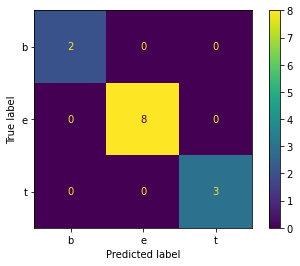

In [ ]:
cm = confusion_matrix(y_test2, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot()

<h1>Compare result with Scikit learn result</h1>

In [ ]:
stemmer = SnowballStemmer(language = 'english')
lem = WordNetLemmatizer()
stop = set(stopwords.words('english'))

def tokenize(document):
  document = document.lower()
  data = [char for char in document if char not in string.punctuation]
  data = ''.join(data)
  data = [word for word in data.split() if word.lower() not in stop]
  data = [stemmer.stem(x,) for x in data]
  data = [lem.lemmatize(x,) for x in data]
  return data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [ ]:

# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df2['TITLE'])

encoder = LabelEncoder()
y = encoder.fit_transform(df2['CATEGORY'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_predicted = nb.predict(x_test)

accuracy_score(y_test, y_predicted) 

1.0

In [ ]:
# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df['review'])

encoder = LabelEncoder()
y = encoder.fit_transform(df['sentiment'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_predicted = nb.predict(x_test)

accuracy_score(y_test, y_predicted) 

0.8467

In [ ]:
# pull the data into vectors
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(df3['v2'])

encoder = LabelEncoder()
y = encoder.fit_transform(df3['v1'])

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

nb = MultinomialNB()
nb.fit(x_train, y_train)
y_predicted = nb.predict(x_test)

accuracy_score(y_test, y_predicted) 

0.9838565022421525


<h1>Conclusion</h1>

We can see that our code perform as well as their code, but it is a bit slow.